In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score


font_path = '../Font/GmarketSansTTFMedium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

In [2]:
seoul = pd.read_csv('../Data/preprocessing/seoul_real_transcation_price.csv')

In [3]:
seoul.head(5)

,시도명,시군구명,관리기관,회사명,공장구분,단지명,설립구분,입주형태,보유구분,등록구분,...,지식산업센터명,대표업종,업종명,업종코드,차수,법인주소,필지수,공장주소,공장주소_지번,공장관리번호
0,서울특별시,종로구,서울특별시 종로구,남일문화 (주),개별,,일반,해당없음,임대,신규등록,...,,18111,경 인쇄업 외 2 종,"181,111,811,318,119",10,서울특별시 종로구 자하문로16길 8 (창성동),1,서울특별시 종로구 자하문로16길 8 (창성동),서울특별시 종로구 창성동 87-1번지,1.110000e+14
1,서울특별시,종로구,서울특별시 종로구,(주)에취.알.디,개별,,일반,해당없음,임대,등록변경,...,,33932,전시용 모형 제조업,33932,10,서울특별시 종로구 통의동 35-69번지,1,서울특별시 종로구 통의동 35-69번지,서울특별시 종로구 통의동 35-69번지,1.110000e+14
2,서울특별시,종로구,서울특별시 종로구,(주)코리아쉬핑가제트,개별,,일반,해당없음,자가,등록변경,...,,58113,일반 서적 출판업 외 3 종,"58,113,181,111,811,300,000",10,서울특별시 도봉구 창동 181-17번지 쌍용아파트 115-1902,1,서울특별시 종로구 자하문로2길 13-3 (통의동),서울특별시 종로구 통의동 35-6번지,1.110000e+14
3,서울특별시,종로구,서울특별시 종로구,삼영DP,개별,,일반,해당없음,임대,신규등록,...,,18111,경 인쇄업 외 2 종,"181,111,811,318,119",10,서울특별시 종로구 사직로 125 (적선동),1,서울특별시 종로구 사직로 125 (적선동),서울특별시 종로구 적선동 107-1번지,1.110000e+14
4,서울특별시,종로구,서울특별시 종로구,삼진기획,개별,,일반,해당없음,임대,등록변경,...,,18119,기타 인쇄업 외 1 종,"1,811,918,113",10,서울특별시 서대문구 홍제동 -번지 문화촌현대아파트 103-1101호,1,서울특별시 종로구 적선동 2번지,서울특별시 종로구 적선동 2번지,1.110000e+14


In [4]:
seoul.columns

Index(['시도명', '시군구명', '관리기관', '회사명', '공장구분', '단지명', '설립구분', '입주형태', '보유구분',
       '등록구분', '전화번호', '남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원', '종업원합계',
       '생산품', '원자재', '공장규모', '용도지역', '지목', '용지면적', '제조시설면적', '부대시설면적', '건축면적',
       '지식산업센터명', '대표업종', '업종명', '업종코드', '차수', '법인주소', '필지수', '공장주소',
       '공장주소_지번', '공장관리번호'],
      dtype='object')

### 삭제할 칼럼
시도명, 시군구명, 관리기관, 회사명, 단지명, 전화번호, 법인주소, 필지수, 공장주소, 공장관리번호, 시

### 보류 칼럼 (일단 삭제)
생산품, 원자재, 업종명, 대표업종, 차수, 필지수

### 전처리 진행
용도지역, 업종코드 값 000 제거, 공장주소 지번 -> 동으로 쪼개기

### feature importance
- 중요도가 낮은 칼럼의 경우 삭제하고 진행

In [5]:
seoul = seoul.drop(columns=['시도명', '시군구명', '관리기관', '회사명', '단지명', '전화번호', '법인주소', '필지수', '공장주소', '공장관리번호']) #1차
seoul = seoul.drop(columns=['생산품', '원자재', '업종명', '업종코드', '차수']) #2차
seoul = seoul.drop(columns=['용도지역', '등록구분', '지목', '보유구분']) #feature importance를 통해서 중요도가 낮은 칼럼은 삭제

In [6]:
seoul.head(3)

,공장구분,설립구분,입주형태,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종,공장주소_지번
0,개별,일반,해당없음,0,0,0,0,0,소기업,238.00,57.12,69.44,126.56,,18111,서울특별시 종로구 창성동 87-1번지
1,개별,일반,해당없음,5,2,0,0,7,소기업,157.55,79.11,78.44,157.55,,33932,서울특별시 종로구 통의동 35-69번지
2,개별,일반,해당없음,12,12,0,0,24,소기업,160.30,92.40,67.90,160.30,,58113,서울특별시 종로구 통의동 35-6번지


### 공장주소_지번을 시, 구, 동으로 구분하기

In [7]:
address = seoul['공장주소_지번'].str.split(n=2, expand=True)
address[2] = address[2].str.split().str[0] #남은 부분에서 첫번째만 분리

print(address)

address.columns = ['시', '구', '동']
seoul = pd.concat([seoul, address[['시', '구', '동']]], axis=1)
seoul = seoul.drop(columns=['공장주소_지번', '시', '동'])


           0    1    2
0      서울특별시  종로구  창성동
1      서울특별시  종로구  통의동
2      서울특별시  종로구  통의동
3      서울특별시  종로구  적선동
4      서울특별시  종로구  적선동
...      ...  ...  ...
11628  서울특별시  강동구  천호동
11629  서울특별시  강동구  천호동
11630  서울특별시  강동구  천호동
11631  서울특별시  강동구  천호동
11632  서울특별시  강동구  천호동

[11633 rows x 3 columns]


In [8]:
seoul.head(3)

,공장구분,설립구분,입주형태,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종,구
0,개별,일반,해당없음,0,0,0,0,0,소기업,238.00,57.12,69.44,126.56,,18111,종로구
1,개별,일반,해당없음,5,2,0,0,7,소기업,157.55,79.11,78.44,157.55,,33932,종로구
2,개별,일반,해당없음,12,12,0,0,24,소기업,160.30,92.40,67.90,160.30,,58113,종로구


In [9]:
seoul.columns

Index(['공장구분', '설립구분', '입주형태', '남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원',
       '종업원합계', '공장규모', '용지면적', '제조시설면적', '부대시설면적', '건축면적', '지식산업센터명', '대표업종',
       '구'],
      dtype='object')

In [10]:
value_counts_df = seoul['지식산업센터명'].value_counts().reset_index()
value_counts_df.columns = ['지식산업센터명', '빈도수']

# Display the DataFrame
print(value_counts_df.to_string(index=False))

                      지식산업센터명  빈도수
                              7225
                     SK트윈테크타워   98
                    대륭테크노타운8차   93
                   대륭테크노타운12차   92
                 벽산/경인디지털밸리2차   86
                     우림라이온스밸리   76
                    대륭테크노타운3차   65
                     현대지식산업센터   60
                    벽산디지털밸리5차   55
                       한신IT타워   54
                      한라시그마밸리   53
                        센터플러스   51
                   대륭테크노타운 5차   51
                      디지털엠파이어   50
                           SK   50
                     갑을그레이트밸리   50
                   대륭테크노타운 6차   50
                      호서대벤처타워   48
                   우림라이온스밸리2차   47
                  에이스하이엔드타워9차   46
                    에이스하이엔드타워   46
                에이스하이엔드타워 클래식   46
                    에스티엑스브이타워   45
                 에이스하이엔드8차(주)   45
                    벽산디지털밸리6차   43
                  에이스테크노타워 1차   43
                 에이스하이엔드타워10차   42
                    

In [11]:
object_columns = ['공장구분', '설립구분', '입주형태', '공장규모', '지식산업센터명', '대표업종', '구']
int_columns = ['남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원', '종업원합계','용지면적', '제조시설면적', '부대시설면적', '건축면적']

In [12]:
# object 타입 변환
for column in object_columns:
    seoul[column] = seoul[column].astype('object')

for column in int_columns:
    seoul[column] = seoul[column].astype('int')

## 시각화 함수 

In [13]:
label_encoders = {}
for column in seoul.select_dtypes(include=['object']).columns:
    if column != '구':
        label_encoders[column] = LabelEncoder()
        seoul[column] = label_encoders[column].fit_transform(seoul[column])

# '구' 칼럼 라벨 인코딩
label_encoder_gu = LabelEncoder()
seoul['구'] = label_encoder_gu.fit_transform(seoul['구'])

X = seoul.drop(columns=['구'])
y = seoul['구']

In [14]:
print(X.shape, y.shape)

(11633, 15) (11633,)


In [15]:
y.value_counts()

7     3455
15    1357
6     1215
23    1190
19     845
3      642
17     428
24     341
10     265
0      228
14     208
5      174
22     166
9      155
1      129
18     108
8      105
16     103
12     102
21      94
2       89
20      77
4       65
13      52
11      40
Name: 구, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(7910, 15) (1978, 15) (1745, 15) (7910,) (1978,) (1745,)


In [26]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

# 범주형 피처들을 찾아 리스트에 저장
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)

# 각 범주형 피처에 대해 LabelEncoder 적용
for feature in categorical_features:
    le = LabelEncoder()
    X_train[feature] = le.fit_transform(X_train[feature])
    X_val[feature] = le.transform(X_val[feature])
    X_test[feature] = le.transform(X_test[feature])

# 결과 확인
display(X_train)
display(X_test)

,공장구분,설립구분,입주형태,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종
2548,0,1,9,10,1,2,0,13,1,495,245,54,299,0,165
5896,1,0,5,32,6,1,0,39,1,208,816,636,1452,97,250
2660,0,1,0,5,12,0,0,17,1,904,72,26,98,0,65
8386,1,3,5,2,9,0,0,11,1,66,271,175,446,173,62
3536,0,1,6,4,0,0,0,4,1,0,131,160,292,0,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,0,1,6,1,2,0,0,3,1,170,22,148,170,0,39
9825,0,1,9,24,1,0,0,25,1,601,412,220,632,0,347
4383,0,1,9,11,2,0,0,13,1,359,0,110,110,0,229
1315,0,1,6,1,1,0,0,2,1,0,65,0,65,70,64


,공장구분,설립구분,입주형태,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종
3094,0,1,6,1,0,0,0,1,1,0,66,35,101,0,393
11270,0,1,4,2,2,0,0,4,1,155,60,95,155,89,236
9641,0,1,9,3,7,0,0,10,1,341,303,38,341,0,16
9128,0,1,9,1,0,0,0,1,1,534,15,0,15,0,256
3912,0,1,2,0,3,0,0,3,1,106,25,81,106,0,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7110,1,0,2,10,1,0,0,11,1,0,97,0,97,0,272
9934,0,1,9,2,0,0,0,2,1,0,123,17,140,126,306
2993,0,1,6,4,6,0,0,10,1,0,132,0,132,0,65
1851,0,1,2,5,2,0,0,7,1,147,6,64,70,0,108


In [27]:
print(X_train.info(), X.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7910 entries, 2548 to 5416
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   공장구분      7910 non-null   int32
 1   설립구분      7910 non-null   int32
 2   입주형태      7910 non-null   int32
 3   남자종업원     7910 non-null   int32
 4   여자종업원     7910 non-null   int32
 5   외국인남자종업원  7910 non-null   int32
 6   외국인여자종업원  7910 non-null   int32
 7   종업원합계     7910 non-null   int32
 8   공장규모      7910 non-null   int32
 9   용지면적      7910 non-null   int32
 10  제조시설면적    7910 non-null   int32
 11  부대시설면적    7910 non-null   int32
 12  건축면적      7910 non-null   int32
 13  지식산업센터명   7910 non-null   int32
 14  대표업종      7910 non-null   int32
dtypes: int32(15)
memory usage: 525.3 KB
None 공장구분        0
설립구분        0
입주형태        0
남자종업원       0
여자종업원       0
외국인남자종업원    0
외국인여자종업원    0
종업원합계       0
공장규모        0
용지면적        0
제조시설면적      0
부대시설면적      0
건축면적        0
지식산업센터명     0
대표업종        0
dtype

In [28]:
from tarfile import XGLTYPE
#학습을 위한 라이브러리 세팅
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier

#평가지표
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



#모델 훈련 함수
def train_models(X_train, y_train):
    models = {
        "XGBClassifier": XGBClassifier(),
        "LGBMClassifier": LGBMClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        # "CatBoostClassifier": CatBoostClassifier(verbose=0)  # verbose=0으로 설정하여 학습 중 메시지 출력을 최소화
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        models[name] = model

    return models


In [29]:
#train, val 시각화 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 결과 시각화 함수
def evaluate_models(models, X_train, y_train, X_val, y_val):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTrain Accuracy\tVal Accuracy\tTrain F1\tVal F1"
    print(header)
    print("-" * len(header))

    for name, model in models.items():
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)

        accuracy_train = accuracy_score(y_train, pred_train)
        accuracy_val = accuracy_score(y_val, pred_val)
        f1_train = f1_score(y_train, pred_train, average='macro')
        f1_val = f1_score(y_val, pred_val, average='macro')

        print(f"{name.ljust(max_name_length)}\t{accuracy_train:.4f}\t\t{accuracy_val:.4f}\t\t{f1_train:.4f}\t\t{f1_val:.4f}")

In [30]:
#모델 test 평가 함수
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# train, val 시각화 함수
def plot_accuracy_for_models(models, X_train, y_train, X_val, y_val):
    # 모델별 정확도 저장을 위한 리스트
    train_accuracy_list = []
    val_accuracy_list = []
    model_names = []

    # 각 모델별로 정확도 계산
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_accuracy = accuracy_score(y_train, train_pred)
        val_accuracy = accuracy_score(y_val, val_pred)

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        model_names.append(name)

    # 선형 그래프로 정확도 결과 시각화
    plt.figure(figsize=(15, 7))
    plt.plot(model_names, train_accuracy_list, marker='o', label='Training Accuracy')
    plt.plot(model_names, val_accuracy_list, marker='o', label='Validation Accuracy')

    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Different Models')
    plt.legend()

    plt.show()

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve, auc

def plot_auc_pr_curve(models, X_val, y_val):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        # 모델에 따라 predict_proba 또는 decision_function을 사용해야 할 수 있음
        if hasattr(model, "predict_proba"):
            probas_pred = model.predict_proba(X_val)[:, 1]
        else:  # 예를 들어 SVM과 같은 경우
            probas_pred = model.decision_function(X_val)

        precision, recall, _ = precision_recall_curve(y_val, probas_pred)
        auc_score = auc(recall, precision)

        plt.plot(recall, precision, label=f'{name} (AUC-PR = {auc_score:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Different Models')
    plt.legend()
    plt.show()

In [32]:
#모델 훈련
import matplotlib.pyplot as plt

# 모델 test 평가 함수
def evaluate_models_on_test(models, X_test, y_test):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Test Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTest Accuracy\t\tTest F1-Score"
    print(header)
    print("-------------------------------------------------------------------------------------")

    for name, model in models.items():
        pred_test = model.predict(X_test)

        accuracy_test = accuracy_score(y_test, pred_test)
        f1_score_test = f1_score(y_test, pred_test, average='macro')

        print(f"{name.ljust(max_name_length)}\t{accuracy_test:.4f}\t\t{f1_score_test:.4f}")

In [33]:
#모델 훈련
models = train_models(X_train, y_train)

In [34]:
#모델 성능평가
evaluate_models(models, X_train, y_train, X_val, y_val)

Model Performance Evaluation:

Model                  	Train Accuracy	Val Accuracy	Train F1	Val F1
-------------------------------------------------------------------
XGBClassifier          	0.9912		0.6062		0.9955		0.2708
LGBMClassifier         	0.9957		0.6127		0.9983		0.2803
RandomForestClassifier 	0.9999		0.5222		0.9999		0.2079


In [ ]:
#모델 test평가
evaluate_models_on_test(models, X_test, y_test)

Model Test Performance Evaluation:

Model                  	Test Accuracy		Test F1-Score
-------------------------------------------------------------------------------------
XGBClassifier          	0.5916		0.2440
LGBMClassifier         	0.5979		0.2367
RandomForestClassifier 	0.5132		0.1951


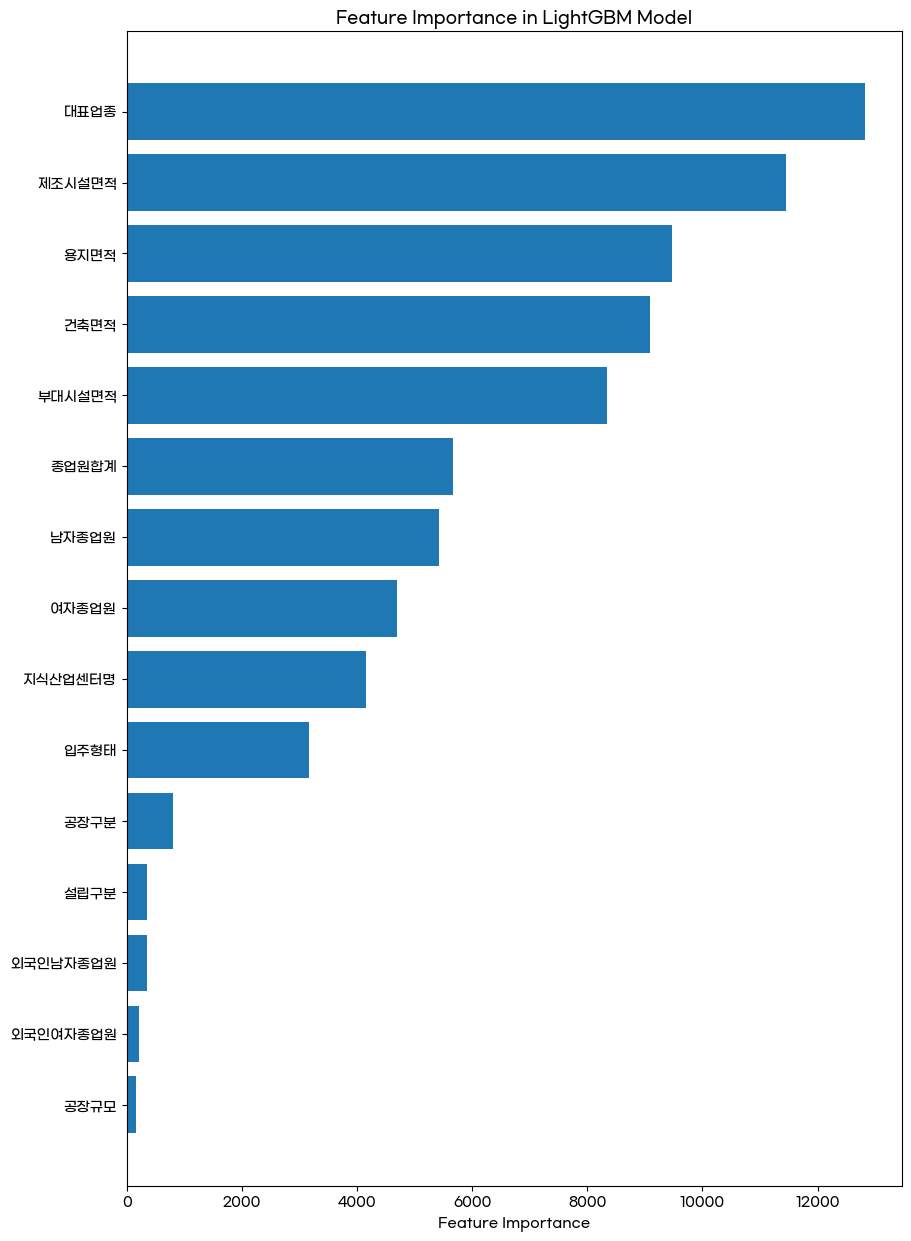

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋의 특성(열) 이름을 가져옵니다.
features = X_train.columns

# LightGBM 모델의 특성 중요도를 가져오고 정렬합니다.
lgbm_model = models['LGBMClassifier']
feature_importances = lgbm_model.feature_importances_
sorted_idx = feature_importances.argsort()

# 그래프 크기 설정
plt.figure(figsize=(10, 15))

# 특성 중요도를 시각화합니다.
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in LightGBM Model')
plt.show()
